<a href="https://colab.research.google.com/github/liululu17/GreenPathSF/blob/main/CreatPoints_Step1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install fiona pandas

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import fiona
import pandas as pd
from shapely.geometry import shape
import fiona
import pandas as pd
from shapely.geometry import shape

def convert_encoding(input_shp, output_shp, original_encoding='utf-8', target_encoding='ISO-8859-1'):
    # Read shapefile and convert to DataFrame
    with fiona.open(input_shp, 'r', encoding=original_encoding) as source:
        records = [feat for feat in source]
        crs = source.crs
        driver = source.driver
        schema = source.schema

    # Create DataFrame from records
    df = pd.DataFrame([feat['properties'] for feat in records])

    # Convert all string columns to target encoding
    str_cols = df.select_dtypes(include=[object])
    df[str_cols.columns] = str_cols.apply(lambda x: x.str.encode('utf-8').str.decode('ISO-8859-1', 'ignore'))

    # Write the updated DataFrame back to a new shapefile
    with fiona.open(output_shp, 'w', driver=driver, crs=crs, schema=schema, encoding=target_encoding) as dest:
        for record, properties in zip(records, df.to_dict(orient='records')):
            # Create a new feature with the updated properties
            new_feature = {
                'type': 'Feature',
                'id': record['id'],
                'properties': properties,
                'geometry': record['geometry']
            }
            dest.write(new_feature)

# Usage
input_shp_1 = '/content/drive/MyDrive/C257 Project/Data/SFDT_shp/SF_DT_CL2/SF_DT_Clean2.shp'
output_shp_1 = '/content/drive/MyDrive/C257 Project/Data/SFDT_shp/SF_DT_CL2/SF_DT_Clean2_P.shp'
convert_encoding(input_shp_1, output_shp_1)


In [ ]:
import geopandas as gpd
from pyproj import CRS

def convert_to_wgs84(input_shp, output_shp):
    # Load the shapefile
    data = gpd.read_file(input_shp)

    # Check if the shapefile is already in WGS84
    if data.crs.to_string() != 'EPSG:4326':
        # Convert the coordinate system to WGS84
        data = data.to_crs(CRS('EPSG:4326'))
    else:
        print("Shapefile is already in WGS84 format.")

    # Save the converted shapefile
    data.to_file(output_shp)

# Usage
input_shp_2 = '/content/drive/MyDrive/C257 Project/Data/SFDT_shp/SF_DT_CL2/SF_DT_Clean2_P.shp'
output_shp_2 = '/content/drive/MyDrive/C257 Project/Data/SFDT_shp/SF_DT_CL2/SF_DT_Clean2_WGS.shp'
convert_to_wgs84(input_shp_2, output_shp_2)


Shapefile is already in WGS84 format.


In [ ]:
converted_data = gpd.read_file('/content/drive/MyDrive/C257 Project/Data/SFDT_shp/SF_DT_CL2/SF_DT_Clean2_WGS.shp')
print(converted_data.crs)

EPSG:4326


In [ ]:
pip install pyproj

In [ ]:
# This program is used in the first step of the Treepedia project to get points along street
# network to feed into GSV python scripts for metadata generation.
# Copyright(C) Ian Seiferling, Xiaojiang Li, Marwa Abdulhai, Senseable City Lab, MIT
# First version July 21 2017


# now run the python file: createPoints.py, the input shapefile has to be in projection of WGS84, 4326
def createPoints(inshp, outshp, mini_dist):

    '''
    This function will parse throigh the street network of provided city and
    clean all highways and create points every mini_dist meters (or as specified) along
    the linestrings
    Required modules: Fiona and Shapely

    parameters:
        inshp: the input linear shapefile, must be in WGS84 projection, ESPG: 4326
        output: the result point feature class
        mini_dist: the minimum distance between two created point

    last modified by Xiaojiang Li, MIT Senseable City Lab

    '''

    import fiona
    import os,os.path
    from shapely.geometry import shape,mapping
    from shapely.ops import transform
    from functools import partial
    import pyproj
    from fiona.crs import from_epsg
    from pyproj import Proj, Transformer

    with fiona.open(inshp) as source:
        if source.crs.get('init') != 'epsg:4326':
            print("Input shapefile CRS is not WGS84. Please convert it to EPSG:4326.")
            return
        else:
            print("Input shapefile is in WGS84 CRS.")

    count = 0
    s = {'motorway','motorway_link','steps', None, 'trunk'}

    # the temporaray file of the cleaned data
    root = os.path.dirname(inshp)
    basename = 'clean_' + os.path.basename(inshp)
    temp_cleanedStreetmap = os.path.join(root,basename)

    # if the tempfile exist then delete it
    if os.path.exists(temp_cleanedStreetmap):
        fiona.remove(temp_cleanedStreetmap, 'ESRI Shapefile')

    # clean the original street maps by removing highways, if it the street map not from Open street data, users'd better to clean the data themselve
    with fiona.open(inshp) as source, fiona.open(temp_cleanedStreetmap, 'w', driver=source.driver, crs=source.crs,schema=source.schema) as dest:

        for feat in source:
            try:
                i = feat['properties']['highway'] # for the OSM street data
                if i in s:
                    continue
            except:
                # if the street map is not osm, do nothing. You'd better to clean the street map, if you don't want to map the GVI for highways
                key = dest.schema['properties'].keys()[0] # get the field of the input shapefile and duplicate the input feature
                i = feat['properties'][key]
                if i in s:
                    continue

            dest.write(feat)

    schema = {
        'geometry': 'Point',
        'properties': {'id': 'int'},
    }

    # Create pointS along the streets
    with fiona.Env():
      crs = {'init': 'epsg:4326'}
      with fiona.open(outshp, 'w', crs=crs, driver='ESRI Shapefile', schema=schema) as output:
          for line in fiona.open(temp_cleanedStreetmap):
              first = shape(line['geometry'])
              length = first.length

              # Create a transformer to convert degree to meter (EPSG:4326 to EPSG:3857)
              transformer_to_3857 = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)
              transformer_to_4326 = Transformer.from_crs("epsg:3857", "epsg:4326", always_xy=True)

              # Apply transformation
              line2 = transform(transformer_to_3857.transform, first)
              dist = mini_dist  # set
              for distance in range(0, int(line2.length), dist):
                  point = line2.interpolate(distance)

                  # Convert the local projection back to the WGS84 and write to the output shp
                  point = transform(transformer_to_4326.transform, point)
                  output.write({'geometry': mapping(point), 'properties': {'id': 1}})


    print("Process Complete")

    # delete the temprary cleaned shapefile
    fiona.remove(temp_cleanedStreetmap, 'ESRI Shapefile')


# Example to use the code,
# Note: make sure the input linear featureclass (shapefile) is in WGS 84 or ESPG: 4326
# ------------main ----------
if __name__ == "__main__":
    import os,os.path
    root = '/content/drive/MyDrive/C257 Project/Data/SFDT_shp/SF_DT_CL2'
    inshp = os.path.join(root,'SF_DT_Clean2_WGS.shp')
    outshp = os.path.join(root,'SF_Sample_100m.shp')
    mini_dist = 100 #the minimum distance between two generated points in meter
    createPoints(inshp, outshp, mini_dist)

Input shapefile is in WGS84 CRS.
Process Complete


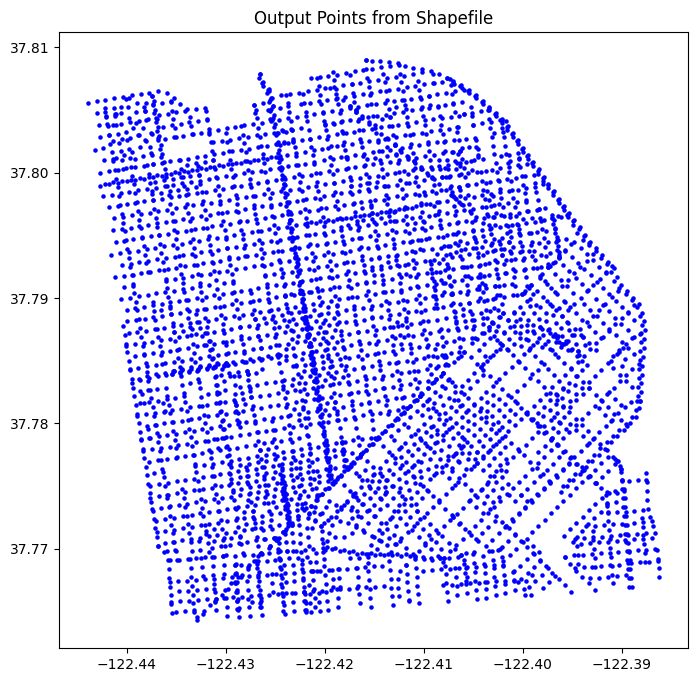

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Path to your output shapefile
shapefile_path = '/content/drive/MyDrive/C257 Project/Data/SFDT_shp/SF_DT_CL2/SF_Sample_100m.shp'

# Load the shapefile
gdf = gpd.read_file(shapefile_path)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, color='blue', marker='o', markersize=5)
ax.set_title('Output Points from Shapefile')
plt.show()

In [ ]:
len(gdf)

4931